In [531]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform, expon

from sklearn.preprocessing import  OrdinalEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, root_mean_squared_error


import warnings
warnings.filterwarnings('ignore')


In [474]:
df = pd.read_csv('titanic.csv')

In [475]:
pd.set_option("display.max_columns", None)

In [476]:
titanic = df.copy()

In [477]:
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [478]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [479]:
x = titanic.drop(columns=['Survived', 'PassengerId', 'Ticket'])
y = titanic['Survived']

In [480]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state= 42)

In [481]:
x_train.shape

(712, 9)

In [482]:
y_train.shape

(712,)

Some Feature Engineering using Custom Transformers:

In [483]:
class FamilySize(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 SibSp_feature: str = 'SibSp', 
                 Parch_feature: str = 'Parch',
                 isalone: bool = 'IsAlone',
                 familysize: int = 'FamilySize'):
        
        self.SibSp_feature = SibSp_feature
        self.Parch_feature = Parch_feature
        self.isalone = isalone
        self.familysize = familysize
    
    def fit(self, data, y=None) -> None:
        
        return self
    

    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        """Perform whether a passenger is Alone or Not"""
        
        new_data = data.copy()
        family_size = data[self.SibSp_feature] + data[self.Parch_feature]
        new_data[self.familysize] = family_size.fillna(0)
        new_data[self.isalone] = family_size.apply(lambda x: 1 if x == 0 else 0).fillna(1)

        return new_data
        

In [484]:
class HasCabin(BaseEstimator, TransformerMixin):
    """
    Check whether the passenger has Cabin or not.
    Return:
        null -> 0
        else -> 1
    """
    def __init__(self, cabin: str = 'Cabin', has_cabin: bool = 'HasCabin'):
        
        self.cabin = cabin
        self.has_cabin = has_cabin
    

    def fit(self, data, y=None) -> None:
        
        return self
    

    def extract_cabin(self, cabin: str) -> bool:
        
        if pd.isna(cabin):
            return 0
        else:
            return 1
        
        
    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        
        new_data = data.copy()
        new_data[self.has_cabin] = data[self.cabin].apply(self.extract_cabin)

        return new_data

In [485]:
class CabinType(BaseEstimator, TransformerMixin):
    """
    Extract the type of Cabin if there is. If null return 'M'.
    Return:
        Cabin Type
    """
    def __init__(self, cabin_feature: str = 'Cabin', CabinType: str= 'CabinType'):
       
        self.cabin_feature = cabin_feature
        self.CabinType = CabinType


    def fit(self, data: pd.DataFrame, y=None) -> None:
        
        return self
    

    def type_extract(self, cabin: str) -> str:
       
        if not isinstance(cabin, str) or pd.isna(cabin):
            return 'M'
        return cabin[0]


    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        
        new_data = data.copy()
        new_data[self.CabinType] = data[self.cabin_feature].apply(self.type_extract)
        new_data[self.CabinType]= LabelEncoder().fit_transform(new_data[self.CabinType])

        return new_data
        

In [486]:
class NameTitle(BaseEstimator, TransformerMixin):
    """Return the title of each passenger"""
    def __init__(self, name: str = 'Name', name_title: str = 'NameTitle') -> None:
       
        self.name = name
        self.name_title = name_title        


    def fit(self, data: pd.DataFrame, y=None) -> None:
        
        return self
    

    def title_extract(self, name: str) -> str:
        
        return name.split(', ')[1].split('.')[0].strip()


    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
       
        new_data = data.copy()
        new_data[self.name_title] = data[self.name].apply(self.title_extract)
        # Fill Null values with most frequent one.
        new_data[self.name_title] = new_data[self.name_title].fillna(new_data[self.name_title].mode()) 
        new_data[self.name_title] = LabelEncoder().fit_transform(new_data[self.name_title])
        return new_data

In [487]:
class AgeFareLog(BaseEstimator, TransformerMixin):
    """Return the LOG of Age and Fare in a new feature named AgeLog and FareLog."""
    def __init__(self, 
                 age: str= 'Age', 
                 age_log: str = 'AgeLog', 
                 fare: str = 'Fare', 
                 fare_log: str = 'FareLog') -> None:
        
        self.age = age
        self.age_log = age_log
        self.fare = fare
        self.fare_log = fare_log


    def fit(self, data: pd.DataFrame, y=None) -> None:
        
        return self
    
    
    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        
        new_data = data.copy()
        new_data[self.age].fillna(new_data[self.age].median())
        new_data['Fare'] = new_data['Fare'].fillna(new_data['Fare'].mean())
        new_data[self.age_log] = np.log(data[self.age] + 1).fillna(0)
        new_data[self.fare_log] = np.log(data[self.fare] + 1).fillna(0)

        return new_data

In [488]:
class EncoderTransform(BaseEstimator, TransformerMixin):
    def __init__(self, sex: str = 'Sex', embarked: str = 'Embarked') -> None:
        
        self.sex = sex
        self.embarked = embarked


    def fit(self, data, y=None) -> None:
        return self
    
    
    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        
        new_data = data.copy()
        new_data[self.sex] = new_data[self.sex].fillna(new_data[self.sex].mode()[0]) 
        # [0]: to ensure it return a scalar rather than a series. .mode() return a pd.Series
        new_data[self.embarked] = new_data[self.embarked].fillna(new_data[self.embarked].mode()[0])
        new_data[self.sex] = OrdinalEncoder().fit_transform(new_data[[self.sex]])
        new_data[self.embarked] = LabelEncoder().fit_transform(new_data[[self.embarked]])

        return new_data

In [489]:
# class CategoryTransform(BaseEstimator, TransformerMixin):
#     def __init__(self, features: list[str]= None) -> None:
#         self.features = features or ['CabinType', 'NameTitle', 'Sex', 'Embarked']
        
#     def fit(self, data: pd.DataFrame, y=None):
#         missing_features = [feature for feature in self.features if feature not in data.columns]
#         if missing_features:
#             raise ValueError(f"Missing required features in input data: {missing_features}")
#         self.new_data = data.copy()
#         self.onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='if_binary')
#         self.ohe_ = self.onehot.fit(self.new_data[self.features])
#         self.ohe_features = self.ohe_.get_feature_names_out(self.features)
#         return self
    
#     def transform(self, data):
#         missing_features = [feature for feature in self.features if feature not in data.columns]
#         if missing_features:
#             raise ValueError(f"Missing required features in input data: {missing_features}")
#         transformed = self.ohe_.transform(self.new_data[self.features])
#         df = pd.DataFrame(transformed, columns= self.ohe_features, index= data.index)
#         return df

In [490]:
class DropTransform(BaseEstimator, TransformerMixin):
    def __init__(self, features: list[str] = None) -> None:
        
        self.features = features or ['Name', 'Age', 'Cabin', 'Fare', 'Parch', 'SibSp']
        

    def fit(self, data: pd.DataFrame, y=None) -> None:
        missing_features = [feature for feature in self.features if feature not in data.columns]
        if missing_features:
            raise ValueError(f"The following features are not present in the data {missing_features}")
        
        return self
    
    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        # print(f"Attempting to drop columns: {self.features}")
        # print(f"Available columns in data: {list(data.columns)}")
        remain_columns = data.drop(columns= self.features, axis= 1, errors='ignore')
        # print(f"Remained columns: {list(remain_columns.columns)}")
        
        return remain_columns

In [491]:
preprocessing = Pipeline([
                        ('IsAlone', FamilySize()),
                        ('CabinType', CabinType()),
                        ('HasCabin', HasCabin()),
                        ('NameTitle', NameTitle()),
                        ('AgeFareLog', AgeFareLog()),
                        ('encoders', EncoderTransform()),
                        ('dropping' , DropTransform()),
                        ], verbose= False )

In [492]:
sgd_clf = Pipeline([
    ('preprocess', preprocessing),
    (('classifier', SGDClassifier(random_state=42))) 
])

In [532]:
sgd_clf.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('IsAlone', FamilySize()),
                                 ('CabinType', CabinType()),
                                 ('HasCabin', HasCabin()),
                                 ('NameTitle', NameTitle()),
                                 ('AgeFareLog', AgeFareLog()),
                                 ('encoders', EncoderTransform()),
                                 ('dropping',
                                  DropTransform(features=['Name', 'Age',
                                                          'Cabin', 'Fare',
                                                          'Parch',
                                                          'SibSp']))])),
                ('classifier', SGDClassifier(random_state=42))])

In [533]:
y_train_predict = cross_val_predict(sgd_clf, x_train, y_train, cv=5,);

In [495]:
conf_mat = confusion_matrix(y_train, y_train_predict)
conf_mat

array([[380,  64],
       [ 87, 181]], dtype=int64)

Scores on Train Dataset:

In [534]:
acc = cross_val_score(sgd_clf, x_train, y_train, cv=5, scoring='accuracy').mean()
roc = cross_val_score(sgd_clf, x_train, y_train, cv=5 , scoring= 'roc_auc').mean()
precision = precision_score(y_train, y_train_predict)*100 
recall = recall_score(y_train, y_train_predict)*100
f1 = f1_score(y_train, y_train_predict)*100

In [497]:
print('K-fold Results on SGD Classifier:')
print(f'average accuracy is: {acc*100:.2f}%')
print(f'average roc is: {roc*100:.2f}%')
print('Precision, Recall and f1 scores: ')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

K-fold Results on SGD Classifier:
average accuracy is: 78.79%
average roc is: 83.17%
Precision, Recall and f1 scores: 
Precision: 73.88%
Recall: 67.54%
F1 Score: 70.57%


Which Threshold?

In [535]:
y_score = cross_val_predict(sgd_clf, x_train, y_train, cv=5, method='decision_function')

In [499]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_score)

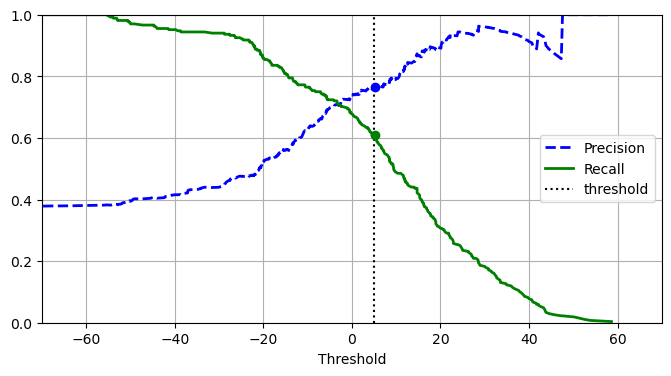

In [500]:
threshold = 5


plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-70, 70, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

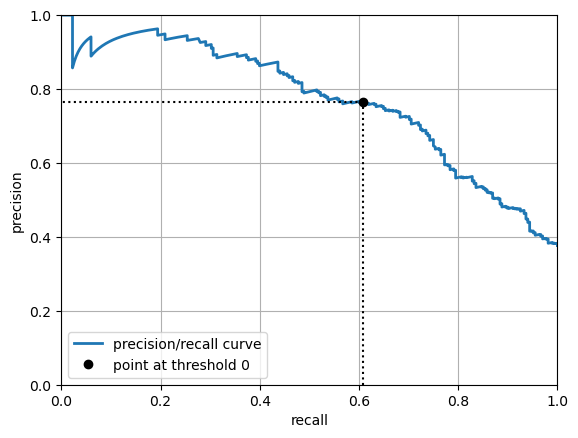

In [501]:
plt.plot( recalls, precisions, linewidth= 2, label = 'precision/recall curve')
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], 'k:')
plt.plot([recalls[idx], 0.], [precisions[idx], precisions[idx]], 'k:')
plt.plot([ recalls[idx]], [precisions[idx]], 'ko', label = 'point at threshold 0')
plt.xlabel('recall')
plt.ylabel('precision')
plt.axis([0., 1., 0., 1.])
plt.grid()
plt.legend(loc = 'lower left')
plt.show()

In [502]:
idx_for_70_precision = (precisions >= 0.70).argmax()
threshold_for_70_precision= thresholds[idx_for_70_precision]
threshold_for_70_precision

-4.378997964359584

In [503]:
fpr_sgd, tpr_sgd, thresholds = roc_curve(y_train, y_score)

In [504]:
idx_for_threshold_at_70 = (thresholds <= threshold_for_70_precision).argmax()
tpr_70, fpr_70 = tpr_sgd[idx_for_threshold_at_70], fpr_sgd[idx_for_threshold_at_70]

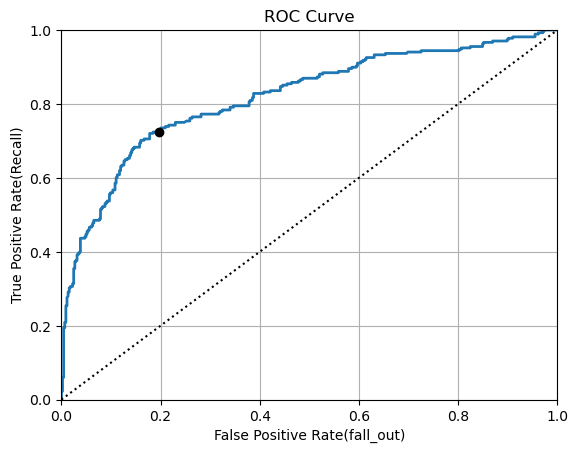

In [505]:
plt.plot(fpr_sgd, tpr_sgd, linewidth=2, label= 'ROC Curve')
plt.plot([0., 1.], [0., 1.], 'k:', label = 'useles test')
plt.plot([fpr_70], [tpr_70], 'ko')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate(fall_out)')
plt.ylabel('True Positive Rate(Recall)')
plt.axis([0., 1., 0., 1.])
plt.grid()

In [506]:
forest_clf = Pipeline([
    ('preprocess', preprocessing),
    (('classifier', RandomForestClassifier(random_state=42))) 
])

In [536]:
forest_clf.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('IsAlone', FamilySize()),
                                 ('CabinType', CabinType()),
                                 ('HasCabin', HasCabin()),
                                 ('NameTitle', NameTitle()),
                                 ('AgeFareLog', AgeFareLog()),
                                 ('encoders', EncoderTransform()),
                                 ('dropping',
                                  DropTransform(features=['Name', 'Age',
                                                          'Cabin', 'Fare',
                                                          'Parch',
                                                          'SibSp']))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [537]:
y_probs_predict = cross_val_predict(forest_clf, x_train, y_train, cv=5, method='predict_proba')

In [509]:
y_probs_predict[-3:-1]

array([[0.54, 0.46],
       [0.23, 0.77]])

In [510]:
y_score_forest = y_probs_predict[:,1]

In [511]:
precisions_forest , recalls_forest, thresholds_forest = precision_recall_curve(y_train, y_score_forest)

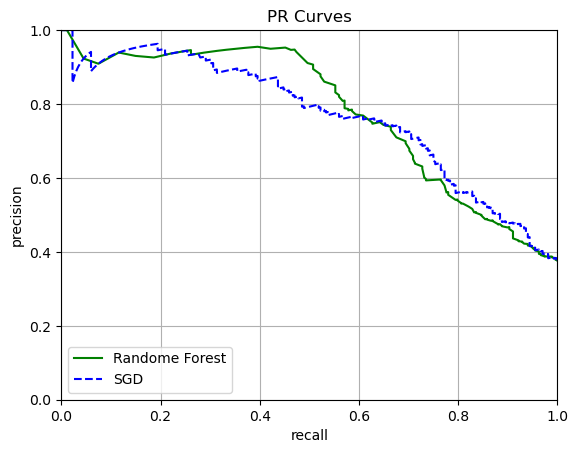

In [512]:
plt.plot(recalls_forest, precisions_forest, 'g-', label = 'Randome Forest')
plt.plot(recalls, precisions, 'b--' ,label= 'SGD')
plt.title('PR Curves')
plt.axis([0., 1., 0., 1.])
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc= 'lower left')
plt.grid()

In [513]:
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train, y_score_forest)

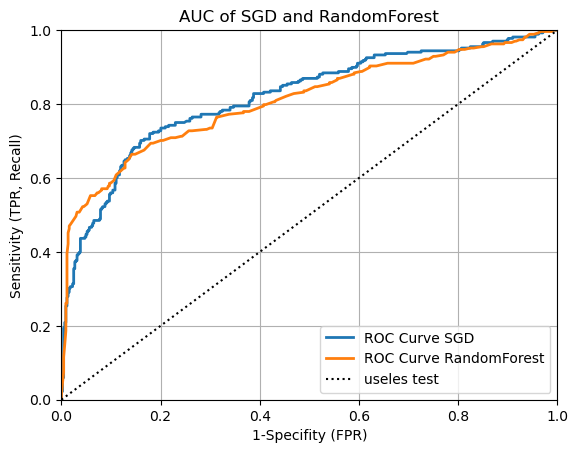

In [514]:
plt.plot(fpr, tpr, linewidth=2, label= 'ROC Curve SGD')
plt.plot(fpr_forest, tpr_forest, linewidth=2, label= 'ROC Curve RandomForest')
plt.plot([0., 1.], [0., 1.], 'k:', label = 'useles test')
plt.title('AUC of SGD and RandomForest')
plt.ylabel('Sensitivity (TPR, Recall)')
plt.xlabel('1-Specifity (FPR)')
plt.legend()
plt.grid()
plt.axis([0., 1., 0., 1.])
plt.show()

In my point of view, if we choose SGD and the threshold something like recall=0.75 and FPR=0.2 is the best choice in this curve. Also in PR curve choosing SGD, with Recall= 0.7 will have the precision=0.7

So, It seems SGD is the better choice here compare to RandomForest classification. 

In [538]:
sgd_pred= sgd_clf.predict(x_test)

In [516]:
print(classification_report(y_test, sgd_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       105
           1       0.76      0.70      0.73        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [539]:
forest_pred= forest_clf.predict(x_test)

In [518]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.85      0.60      0.70       105
           1       0.60      0.85      0.70        74

    accuracy                           0.70       179
   macro avg       0.73      0.73      0.70       179
weighted avg       0.75      0.70      0.70       179



In [519]:
sgd_rmse = root_mean_squared_error(y_train, y_train_predict)
sgd_rmse

0.460519979681005

In [520]:
forest_rmse = root_mean_squared_error(y_train, y_score_forest)
forest_rmse

0.44596622629820265

SVC:

In [521]:
svc_clf = Pipeline([
    ('preprocess', preprocessing),
    (('svc', SVC()))
], verbose=False)

In [522]:
param_distribs_svc = {
                'svc__C': loguniform(20, 200),  
                'svc__gamma': expon(scale = 1.0),
                'svc__kernel': ['rbf', 'linear', 'sigmoid']}

random_search = RandomizedSearchCV(
    svc_clf, param_distributions=param_distribs_svc, n_iter=50, cv = 5, 
    scoring='neg_root_mean_squared_error', random_state=42)

In [540]:
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              Pipeline(steps=[('IsAlone',
                                                               FamilySize()),
                                                              ('CabinType',
                                                               CabinType()),
                                                              ('HasCabin',
                                                               HasCabin()),
                                                              ('NameTitle',
                                                               NameTitle()),
                                                              ('AgeFareLog',
                                                               AgeFareLog()),
                                                              ('encoders',
                                                               EncoderTransform()),
                                                              ('dropping',
                                                               DropTransform(features=['Name',
                                                                                       'Age',
                                                                                       'Cabin',
                                                                                       'Fare',
                                                                                       'Parch',
                                                                                       'SibSp']))])),
                                             ('svc', SVC())]),
                   n_iter=50,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF5357FB30>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF5357E120>,
                                        'svc__kernel': ['rbf', 'linear',
                                                        'sigmoid']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [524]:
random_search.best_params_

{'svc__C': 120.42620370295195,
 'svc__gamma': 0.9084469696321253,
 'svc__kernel': 'linear'}

In [525]:
rnd_search_rmse = - random_search.best_score_
rnd_search_rmse

0.4577800396823288

In [541]:
y_pred_svc = random_search.predict(x_train)

In [527]:
svm_clf = Pipeline([
    ('preprocess', preprocessing),
    (('svc', SVC(C=12.4, gamma=0.9, kernel='linear')))
], verbose=False)

In [542]:
acc = cross_val_score(svm_clf, x_train, y_train, cv=5, scoring='accuracy').mean()
roc = cross_val_score(svm_clf, x_train, y_train, cv=5 , scoring= 'roc_auc').mean()
precision = precision_score(y_train, y_pred_svc)*100 
recall = recall_score(y_train, y_pred_svc)*100
f1 = f1_score(y_train, y_pred_svc)*100

In [529]:
print('K-fold Results on SVC Classifier:')
print(f'average accuracy is: {acc*100:.2f}%')
print(f'average roc is: {roc*100:.2f}%')
print('Precision, Recall and f1 scores: ')
print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1 Score: {f1:.2f}%')

K-fold Results on SVC Classifier:
average accuracy is: 78.93%
average roc is: 81.87%
Precision, Recall and f1 scores: 
Precision: 73.88%
Recall: 67.54%
F1 Score: 70.57%
